In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from utils import nc_to_pd, prepare_simulated

# 1. Satellite dataset for solar irradiance
This dataset can be found publicly at https://wui.cmsaf.eu/safira/action/viewProduktDetails?eid=21985_21986&fid=27

In [4]:
if sys.platform == 'win32':
    save_folder = "F:/Google Drive/Dropbox_Backup/Post Study/Industrial/Courses/DTU Advanced Machine Learning, 2020/gaussian_solar_project/data/"
else:
    save_folder = "/home/local/DAC/ahn/Documents/dcwis.solar/dcwis/solar/reports/dtu/"
    
file_path = '/media/data/CAL_SIS_raw/2015/'
filename = 'full_CAL_SIS_1_of_8.nc'

In [ ]:
cloud_albedo = xr.open_dataset(file_path + filename).load()

In [4]:
data = cloud_albedo['SIS']
print(data.shape)

(2160, 512, 512)


In [5]:
# We sum along lat and lon
summed_data = np.sum(data, axis=(1,2))

In [6]:
# We find indices where there are more than 0 observations (mainly due to night)
indices = np.where(summed_data > 0)[0]
print(len(indices))

# We define the actual time stamps where there are more than 0 observations
timestamps = data.time[indices].values

1023


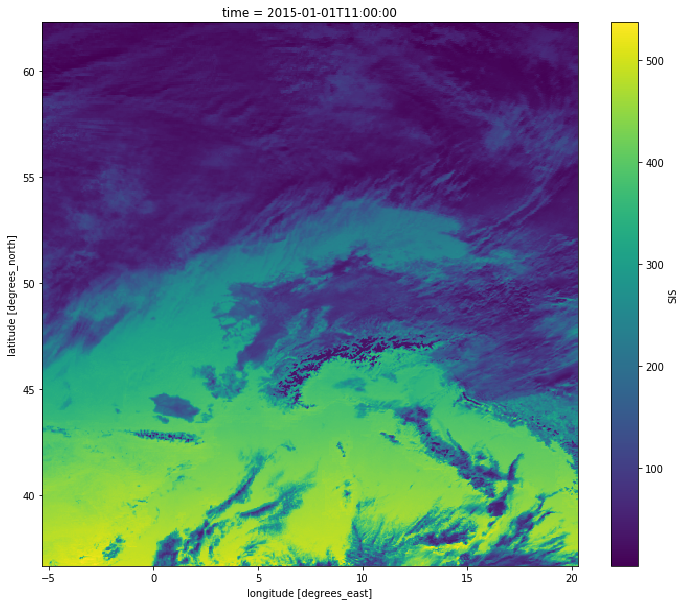

In [7]:
# Then we only select these timestamps from our dataset
data = data.sel(time=timestamps)

# And we resample by mean to hourly observations (to match the next dataset)
data = data.resample(time='1H').mean()

# Lets plot a random data
plt.figure(figsize=(12,10))
data.sel(time=timestamps[10]).plot()

In [8]:
# For our study, we select the approximate lat lon location of the three largest solarpark in Germany 

# Solarpark Meuro 
lat1 = 51.34
lon1 = 13.59

# Neuhardenberg Solar Park
lat2 = 52.37
lon2 = 14.14

# Templin Solar Park
lat3 = 53.02
lon3 = 13.32


data1 = data.sel(lat=lat1, lon=lon1, method='nearest')
data2 = data.sel(lat=lat2, lon=lon2, method='nearest')
data3 = data.sel(lat=lat3, lon=lon3, method='nearest')

In [9]:
# As we are no longer using lat lon, we might as well convert our datasets to pandas and save as csv
meuro_irradiance = nc_to_pd(data1, name='irradiance_meuro_data', save=True, save_folder=save_folder)
neuhardenberg_irradiance = nc_to_pd(data2, name='irradiance_neuhardenberg_data', save=True, save_folder=save_folder)
templin_irradiance = nc_to_pd(data3, name='irradiance_templin_data', save=True, save_folder=save_folder)

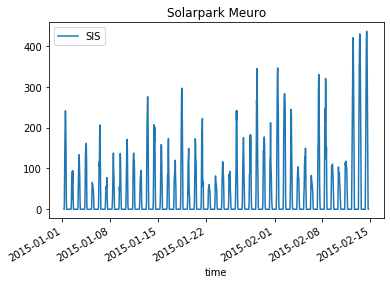

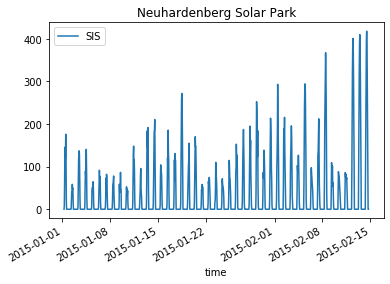

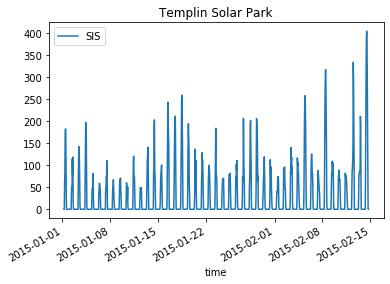

In [10]:
# Lets see how the data looks like

# Solarpark Meuro
meuro_irradiance.plot()
plt.title('Solarpark Meuro')
plt.show()

# Neuhardenberg Solar Park
neuhardenberg_irradiance.plot()
plt.title('Neuhardenberg Solar Park')
plt.show()

# Templin Solar Park
templin_irradiance.plot()
plt.title('Templin Solar Park')
plt.show()

# 2. Actual (simulated) solar production for our three locations
This data comes from https://www.renewables.ninja/.  
This is simulated data that has been generated using various ground-based measurements of solar production versus solar irradiance as measured from satellite (actually, the same satellite dataset that we use above!).



In [11]:
meuro_sim = pd.read_csv(save_folder + 'meuro_simulated.csv', skiprows=[0,1,2])
neuhardenberg_sim = pd.read_csv(save_folder + 'neuhardenberg_simulated.csv', skiprows=[0,1,2])
templin_sim = pd.read_csv(save_folder + 'templin_simulated.csv', skiprows=[0,1,2])

In [12]:
# If we do not process the satellite data, then we import the following saved csv files
use_cached = True

if use_cached:
    meuro_irradiance = pd.read_csv(save_folder + 'irradiance_meuro_data.csv').set_index('time')
    meuro_irradiance.index = pd.to_datetime(meuro_irradiance.index, utc=True)
    
    neuhardenberg_irradiance = pd.read_csv(save_folder + 'irradiance_neuhardenberg_data.csv').set_index('time')
    neuhardenberg_irradiance.index = pd.to_datetime(neuhardenberg_irradiance.index, utc=True)
    
    templin_irradiance = pd.read_csv(save_folder + 'irradiance_templin_data.csv').set_index('time')
    templin_irradiance.index = pd.to_datetime(templin_irradiance.index, utc=True)

In [13]:
# prepare our simulated dataframes
meuro_sim = prepare_simulated(meuro_sim, meuro_irradiance.index)
neuhardenberg_sim = prepare_simulated(neuhardenberg_sim, neuhardenberg_irradiance.index)
templin_sim = prepare_simulated(templin_sim, templin_irradiance.index)

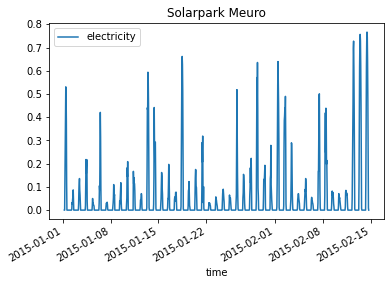

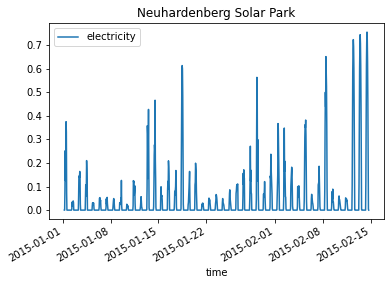

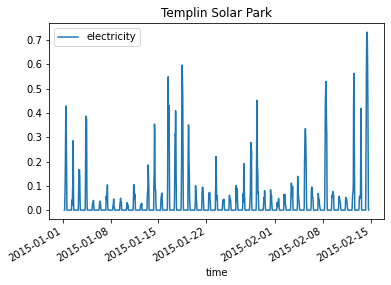

In [14]:
# Lets see how the data looks like

# Solarpark Meuro
meuro_sim.plot()
plt.title('Solarpark Meuro')
plt.show()

# Neuhardenberg Solar Park
neuhardenberg_sim.plot()
plt.title('Neuhardenberg Solar Park')
plt.show()

# Templin Solar Park
templin_sim.plot()
plt.title('Templin Solar Park')
plt.show()

## It should be quite evident when comparing these datasets to the satellite ones that they are very similar! 
This is not surprising given that solar production is a direct function of irradiance
Furthermore, they are both based on the same solar irradiance satellite dataset

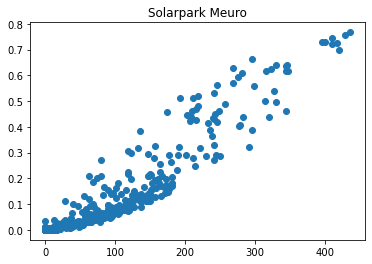

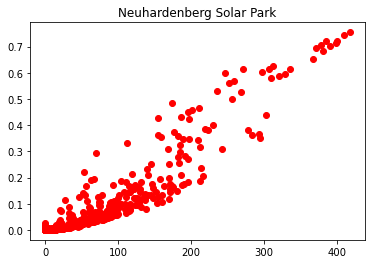

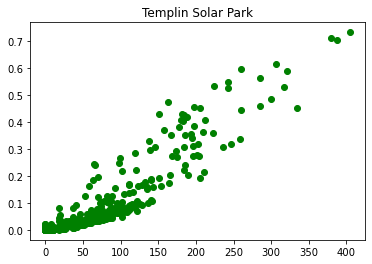

In [15]:
plt.figure()
plt.scatter(meuro_irradiance, meuro_sim)
plt.title('Solarpark Meuro')
plt.show()

plt.figure()
plt.scatter(neuhardenberg_irradiance, neuhardenberg_sim, color='red')
plt.title('Neuhardenberg Solar Park')
plt.show()

plt.figure()
plt.scatter(templin_irradiance, templin_sim, color='green')
plt.title('Templin Solar Park')
plt.show()

**So why do we want to investigate this relationship when it seems relatively linear?**  
Essentially due to uncertainty! In some scenarios, this linear relationship will not hold perfectly due to other reasons such as temperature impacting the solar panels. This is evident when looking at the above scatter plots.

If we could somehow quantify uncertainty regarding this empirical conversion from irradiance to power, that would be of great importance!

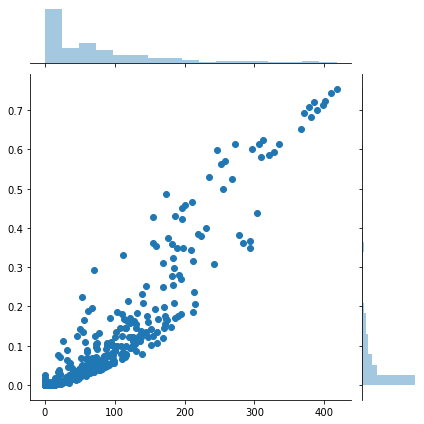

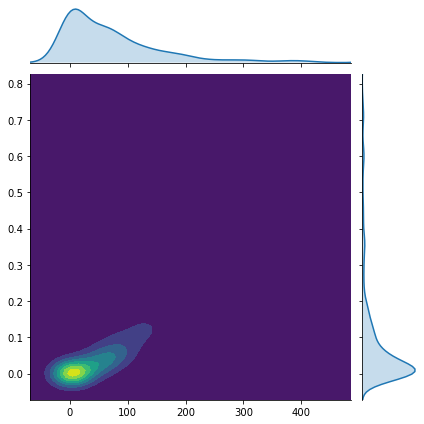

In [16]:
import seaborn as sns
sns.jointplot(x=neuhardenberg_irradiance,y=neuhardenberg_sim,kind='scatter',cmap='viridis'); 
sns.jointplot(x=neuhardenberg_irradiance,y=neuhardenberg_sim,kind='kde',cmap='viridis');

# 3. Gaussian Process Regression

This is where **Gaussian Processes** come in!

Let us try to fit a Gaussian Process Regression to this relationship

In [17]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, DotProduct, ExpSineSquared

## Physical Constraints and Assumptions

Since we have a physical process taking place, we have some physical constraints that we impose upon our problem.
These are:
    
1) The x-values (solar irradiance) $\in$ [0 ; $\infty$]   
2) The y-values (solar production) $\in$ [0 ; 1],   (1 being the total capacity of the solar plant)

##### Let us create a linear space from 0 to 500    on the x-axis (we could increase this, although for our training set this seems valid) 

In [18]:
xpts = np.linspace(0, 500, num=10000)

In [19]:
# Let us instantiate the GP model using a pre-specified kernel (RBF in this case)

kernel = RBF(length_scale=5)
model = gaussian_process.GaussianProcessRegressor(alpha=0.1, optimizer=None, kernel=kernel)

In [20]:
# We fit the model to our observed data
model.fit(meuro_irradiance.values.reshape(-1, 1), meuro_sim)

GaussianProcessRegressor(alpha=0.1, kernel=RBF(length_scale=5), optimizer=None)

In [21]:
y_pred, sigmas = model.predict(xpts.reshape(-1, 1), return_std=True)

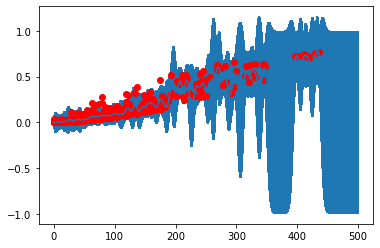

In [22]:
plt.errorbar(xpts, y_pred.ravel(), yerr=sigmas, capsize=0)
plt.plot(meuro_irradiance.values.ravel(), meuro_sim.values.ravel(), "ro")
plt.show()

In [20]:
# AN IDEA COULD BE TO USE BAYESIAN OPTIMIZATION TO SELECT KERNEL??

In [27]:
Xinit

array([[-3, -3],
       [-3,  3],
       [ 3, -3],
       [ 3,  3]])

In [25]:
xpts.shape

(10000,)

In [51]:
# Define function
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
normal = multivariate_normal(mean=[0.3,-0.5], cov=[[2,.1],[.1,2]])
f= lambda x: -normal.pdf(x)
N = 100
x = np.linspace(0,1,N)
x = np.array(np.meshgrid(x,x,indexing='ij')).reshape(2,-1)
# Xinit = np.array([[-3,-3],[-3,3],[3,-3],[3,3]])
# Xinit = np.array([[0,0],[1, 0],[0,400],[1,400]])
Xinit = np.array([[0,0],[0, 1],[1,0],[1,1]])
#GPyOpt
import GPyOpt
bounds2d = [{'name': 'x', 'type': 'continuous', 'domain': (0,1)},
            {'name': 'y', 'type': 'continuous', 'domain': (0,1)}]

bo = GPyOpt.methods.BayesianOptimization(f, domain=bounds2d, X=Xinit, acquisition_type='EI',exact_feval=True)
bo.run_optimization(max_iter = 11)


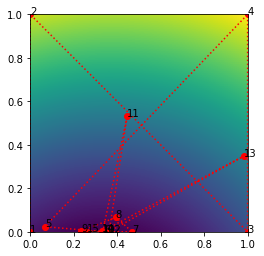

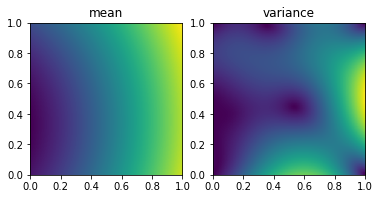

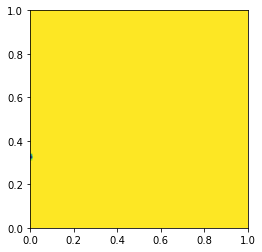

In [52]:

#Plotting
y=f(x.T).reshape(N,N).T
plt.figure('Optimization progress')
plt.imshow(y,cmap='viridis',origin='lower',extent=[x[0][0],x[0][-1],x[1][0],x[1][-1]]);
plt.plot(bo.X[:,0],bo.X[:,1],'ro:')
for i,xx in enumerate(bo.X):
    plt.text(xx[0],xx[1],'%i'%(i+1))
plt.figure('Approximated function')
plt.subplot(1,2,1)
plt.title('mean')
plt.imshow(bo.model.predict(x.T)[0].reshape(N,N),cmap='viridis',origin='lower',extent=[x[0][0],x[0][-1],x[1][0],x[1][-1]]);
plt.subplot(1,2,2)
plt.title('variance')
plt.imshow(bo.model.predict(x.T)[1].reshape(N,N),cmap='viridis',origin='lower',extent=[x[0][0],x[0][-1],x[1][0],x[1][-1]]);
#plt.suptitle('Approximated function')
plt.figure('Acquisition function')
plt.imshow(bo.acquisition.acquisition_function(x.T).reshape(N,N),cmap='viridis',origin='lower',extent=[x[0][0],x[0][-1],x[1][0],x[1][-1]]);

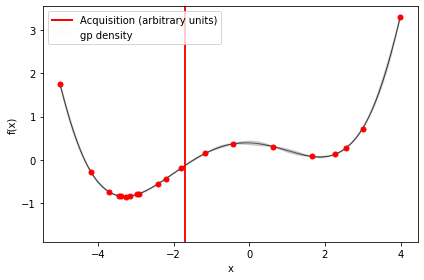

In [60]:
# --- Load GPyOpt
from GPyOpt.methods import BayesianOptimization
import numpy as np

# --- Define your problem
def f(x): return x**4 + 2*x**3 -12*x**2 - 2*x + 6
domain = [{'name': 'var_1', 'type': 'continuous', 'domain': (-5,4)}]

# --- Solve your problem
myBopt = BayesianOptimization(f=f, domain=domain)
myBopt.run_optimization(max_iter=15)
myBopt.plot_acquisition()